In [30]:
def plot_cv_training_and_test_highlights(
    all_metrics,
    all_histories,
    ncols=2,
    include_val_f1=True,
    x_offset=1.0,
    ylim=(0.0, 1.05),
    figsize_per_cell=(7, 4.5),
    suptitle="Training Curves per Fold with Test Performance Highlights",
    save_path=None,
    show=True,
):
    """
    可视化交叉验证每折的训练曲线，并用红/蓝点在右侧高亮测试(外层验证)的 ACC/AUC。

    参数
    ----
    all_metrics : list[dict]
        每折的最终指标字典，至少包含 'ACC', 'AUC'。若含 'BEST_EPOCH' 将用于画竖线。
    all_histories : list[list[dict]] 或 list[pandas.DataFrame]
        每折的逐 epoch 记录。每个元素需包含 'epoch', 'train_ACC'；
        建议包含 'val_ACC', 'val_AUC'；若 include_val_f1=True 且有 'val_F1' 也会绘制。
    ncols : int
        子图每行列数（折数>1 时建议 2）。
    include_val_f1 : bool
        若历史里有 'val_F1'，是否一起绘制。
    x_offset : float
        测试点（红/蓝点）在 x 轴上的偏移（放在最右侧 epoch 的右边）。
    ylim : tuple(float, float)
        y 轴范围。
    figsize_per_cell : tuple(float, float)
        单个子图的宽高（inch）。
    suptitle : str
        总标题。
    save_path : str or None
        若给定路径，将保存图片（如 "cv_plot.png"）。
    show : bool
        是否 plt.show() 直接展示。

    返回
    ----
    fig : matplotlib.figure.Figure
        生成的 figure。
    axes : np.ndarray of Axes
        子图轴数组（按 ravel 排列）。
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    from math import ceil

    # 规范化 histories：每折转成 DataFrame
    histories = [pd.DataFrame(h) if not hasattr(h, "columns") else h for h in all_histories]
    n_folds = len(histories)

    # 计算 BEST_EPOCH（若未提供则取 val_ACC 最大处，否则最后一轮）
    best_epochs = []
    for hist, met in zip(histories, all_metrics):
        if "BEST_EPOCH" in met and met["BEST_EPOCH"]:
            best_epochs.append(int(met["BEST_EPOCH"]))
        else:
            if "val_ACC" in hist.columns and not hist["val_ACC"].isna().all():
                best_epochs.append(int(hist.loc[hist["val_ACC"].idxmax(), "epoch"]))
            else:
                best_epochs.append(int(hist["epoch"].iloc[-1]))

    # 布局
    ncols = max(1, int(ncols))
    nrows = ceil(n_folds / ncols)
    fig = plt.figure(figsize=(figsize_per_cell[0]*ncols, figsize_per_cell[1]*nrows))
    axes = np.array([fig.add_subplot(nrows, ncols, i+1) for i in range(n_folds)])

    # 绘制每折
    for i, (ax, hist, met, be) in enumerate(zip(axes, histories, all_metrics, best_epochs), start=1):
        # 必需字段检查
        if "epoch" not in hist.columns or "train_ACC" not in hist.columns:
            raise ValueError(f"Fold {i}: history 需要包含 'epoch' 与 'train_ACC' 字段。")

        # 曲线：train_ACC / val_ACC / val_AUC / val_F1(可选)
        ax.plot(hist["epoch"], hist["train_ACC"], label="Train ACC", linewidth=2)
        if "val_ACC" in hist.columns:
            ax.plot(hist["epoch"], hist["val_ACC"], label="Val ACC", linewidth=2)
        if "val_AUC" in hist.columns:
            ax.plot(hist["epoch"], hist["val_AUC"], label="Val AUC", linewidth=2, linestyle="--")
        if include_val_f1 and "val_F1" in hist.columns:
            ax.plot(hist["epoch"], hist["val_F1"], label="Val F1", linewidth=1.8, linestyle=":")

        # BEST_EPOCH 竖线
        ax.axvline(be, color="gray", linestyle="--", alpha=0.6)

        # 右侧测试点：ACC(红) / AUC(蓝)
        test_acc = float(met.get("ACC", np.nan))
        test_auc = float(met.get("AUC", np.nan))
        xmax = float(np.nanmax(hist["epoch"]))
        x_pt = xmax + x_offset
        if not np.isnan(test_acc):
            ax.scatter(x_pt, test_acc, color="red", s=60, zorder=5, label="Test ACC")
        if not np.isnan(test_auc):
            ax.scatter(x_pt, test_auc, color="blue", s=60, zorder=5, label="Test AUC")

        # 轴与标题
        ax.set_xlim(min(hist["epoch"].min(), 1) - 0.5, x_pt + x_offset)
        ax.set_ylim(*ylim)
        acc_str = f"ACC={test_acc:.3f}" if not np.isnan(test_acc) else "ACC=NA"
        auc_str = f"AUC={test_auc:.3f}" if not np.isnan(test_auc) else "AUC=NA"
        ax.set_title(f"Fold {i} | Test {acc_str}, {auc_str}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Metric")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend(loc="lower right")

    # 若子图未占满（n_folds < nrows*ncols），隐藏多余
    for j in range(n_folds, nrows*ncols):
        fig.add_subplot(nrows, ncols, j+1).axis("off")

    fig.suptitle(suptitle, fontsize=14, y=1.02)
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()

    return fig, axes


Group prediction
-

IG Edge Weights
-

In [15]:
import numpy as np
from scipy.io import loadmat
import sys
wd='/home/user7/aPopulation_differences/7_KRR_2groups/majorRe1027'
sys.path.append(wd)  

import importlib
import FNN_Group_prediction_FHui_v1107 as m
importlib.reload(m)                   
from FNN_Group_prediction_FHui_v1107 import run_cv_on_random_balanced_subset,vectorize_fc_upper_triangle
import os

##  AUC
groups = np.loadtxt(f'{wd}/AAs101_WAs721_DA.txt').astype(int)
y = np.loadtxt(f'{wd}/AAs101_WAs721_labels_DA.txt').astype(int)
mat_data = loadmat(f'{wd}/HCP_822sub_Cov6_DA.mat')  
C_raw = mat_data['cov_X_DA']

FCs = loadmat(f'{wd}/HCP_S100_Kong2022_gMSHBM_FC_DA.mat')  
X_fc = FCs['HCP_S100_Kong2022_gMSHBM_FC']  # shape: 100*100*Total_numbers
X_fc = vectorize_fc_upper_triangle(X_fc, include_diag=False)
for ind in range(40):
    print(f"seed {42+ind} start")
    fold_objs, all_metrics, summary,all_histories = run_cv_on_random_balanced_subset( X_fc, y, C_raw,groups, n_aa=101, n_wa=101, n_splits=5, seed=42+ind)
    np.savez_compressed(f"./histories/seed_{42+ind}_all_histories.npz",all_histories=np.array(all_histories, dtype=object))
    np.savez_compressed(f"./histories/seed_{42+ind}_all_metrics.npz",all_metrics=np.array(all_metrics, dtype=object))
    print(f"seed {42+ind} end")

Using device: cuda
seed 42 start
Total rows: 4684 | AA samples: 2285 | WA samples: 2399
Total subjects: 202 | AA subj: 101 | WA subj: 101

=== Fold 1/5 (group-stratified) ===
[Inner] Epoch 001 | train_loss=0.3285 | train_ACC=0.8770 | valACC=0.5764 | valAUC=0.6403
[Inner] Epoch 002 | train_loss=0.1212 | train_ACC=0.9698 | valACC=0.5325 | valAUC=0.5929
[Inner] Epoch 003 | train_loss=0.0791 | train_ACC=0.9798 | valACC=0.4927 | valAUC=0.5784
[Inner] Epoch 004 | train_loss=0.0701 | train_ACC=0.9805 | valACC=0.5007 | valAUC=0.5711
[Inner] Epoch 005 | train_loss=0.0345 | train_ACC=0.9919 | valACC=0.4781 | valAUC=0.5497
[Inner] Epoch 006 | train_loss=0.0323 | train_ACC=0.9916 | valACC=0.4940 | valAUC=0.5576
[Inner] Epoch 007 | train_loss=0.0434 | train_ACC=0.9882 | valACC=0.4874 | valAUC=0.5390
[Inner] Epoch 008 | train_loss=0.0391 | train_ACC=0.9889 | valACC=0.4900 | valAUC=0.5364
[Inner] Epoch 009 | train_loss=0.0322 | train_ACC=0.9892 | valACC=0.4701 | valAUC=0.5250
[Inner] Epoch 010 | trai

In [34]:
seed79_his=np.load('/home/user7/aPopulation_differences/7_KRR_2groups/majorRe1027/FNN/FHui/histories/seed_79_all_histories.npz',allow_pickle=True)
seed79_met= np.load('/home/user7/aPopulation_differences/7_KRR_2groups/majorRe1027/FNN/FHui/histories/seed_79_all_metrics.npz',allow_pickle=True)
all_metrics = seed79_met['all_metrics'].tolist()
all_histories = seed79_his['all_histories'].tolist()

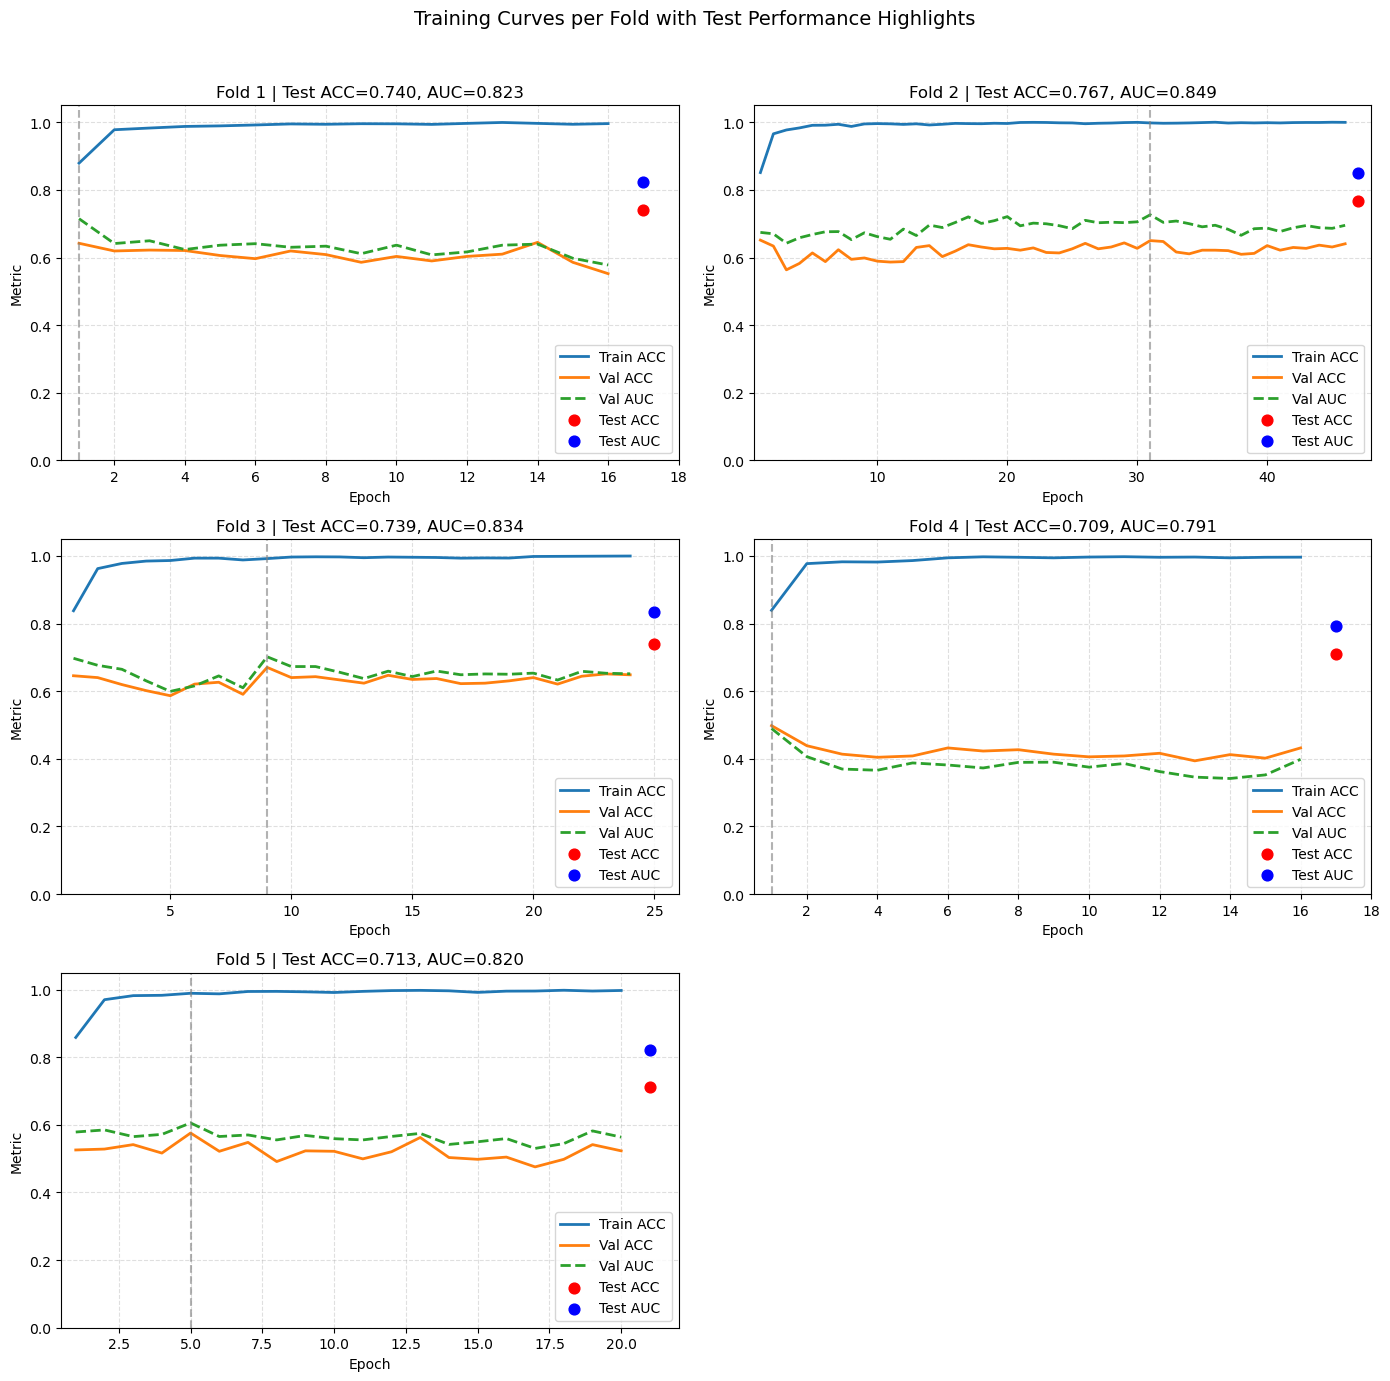

(<Figure size 1400x1350 with 6 Axes>,
 array([<Axes: title={'center': 'Fold 1 | Test ACC=0.740, AUC=0.823'}, xlabel='Epoch', ylabel='Metric'>,
        <Axes: title={'center': 'Fold 2 | Test ACC=0.767, AUC=0.849'}, xlabel='Epoch', ylabel='Metric'>,
        <Axes: title={'center': 'Fold 3 | Test ACC=0.739, AUC=0.834'}, xlabel='Epoch', ylabel='Metric'>,
        <Axes: title={'center': 'Fold 4 | Test ACC=0.709, AUC=0.791'}, xlabel='Epoch', ylabel='Metric'>,
        <Axes: title={'center': 'Fold 5 | Test ACC=0.713, AUC=0.820'}, xlabel='Epoch', ylabel='Metric'>],
       dtype=object))

In [36]:
plot_cv_training_and_test_highlights( all_metrics,all_histories,
                            save_path='/home/user7/aPopulation_differences/7_KRR_2groups/majorRe1027/FNN/FHui/histories/seed_79_performance.pdf')

In [29]:
from scipy.io import savemat

from FNN_Group_prediction_FHui_v1107 import consensus_from_npz_dir,vec_to_mat_,binomial_threshold_counts
consensus, counts, selected, paths = consensus_from_npz_dir(
    "./ig_outputs", file_glob="mlp_ig_*_fold*.npz", use="valid", top_p=0.2,agg='mean',
)

In [4]:
E = counts.shape[0]
n_trials = len(paths)
top_p = 0.2               

sig_mask, pvals, alpha_corr = binomial_threshold_counts(
    counts,
    n_trials=n_trials,
    p0=top_p,
    alpha=0.05,
    bonferroni=True
)

consensus_sig = consensus * sig_mask.astype(float)
R = 100
consensus_mat  = vec_to_mat_(consensus,     R=R, include_diag=False)
consensus_sig_mat = vec_to_mat_(consensus_sig, R=R, include_diag=False)

savemat('consensusWeights.mat', {'sigMask': consensus_sig_mat,'weights': consensus_mat})